# Standalone Alanine Dipeptide Example

In this notebook we provide a (close to) standalone script for training a neural network policy with PICE. In contrast to other notebook/scripts available in the codebase this notebook does not use the formal definition of the system dynamics (as given in eq. 4 & 5 in the paper) as a guideline to structure the code. Instead, this notebook is organised to hihglight the integration between the PICE algorithm, implemented using Pytorch, and the OpenMM framework. 

## Imports

In [1]:
import torch
from tqdm import tqdm

from plotting.PlotPathsAlanine import PlotPathsAlanine
from policies.Alanine import NNPolicy

from openmm import app
import openmm as mm
import openmm.unit as unit
from openmmtools.integrators import VVVRIntegrator

from potentials.md_utils import ForceReporter

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



## Basic Environment setup

In [2]:
# Setup environment
device = 'cuda:6'

# Experimental setup
T = 500.  # Time horizon
n_rollouts = 10 #15000 # Number of epochs
n_samples = 16 # Number of trajectories for each epoch
std = 0.1
lr = 0.0001

# Some specifics about the molecule
u_dim = 22 * 3 # Doesn't include the positions
dim = u_dim * 2 # Full dimension of the statespace

# Derived values
dt = torch.tensor(1.)
n_steps = int(T / dt)

## OpenMM Integration
We abstract all interaction with OpenMM to the single class below. This is a simplification of the full codebase where the interation is shared between the classes in /Dynamics and /potentials. 

In the \_\_init\_\_() function the OpenMM simulation is instantiate using the basic toolset of OpenMM such as the ForceField and VVVRIntegrator. This is mostly standard OpenMM practises. More interesting is the setup of the CustomExternalForce(). This custom external force is used for controlling the molecular dynamics simulation with our PyTorch control policy. 

Consecutively, it is the perform_OpenMM_step() function that interacts with the CustomExternalForce before running a step of the OpenMM simulation. It is here that the control given by the policy is assigned to the placeholder values that describe the force applied to each atom. 

In [7]:
class AlanineOpenMM():
    def __init__(self, start_file, device, overide=True, index=0):
        """
        Intialize the OpenMM configuration
        """
        self.index = index
        self.start_file = start_file
        self.device = device

        # Setup openMM
        self.forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
        self.pdb = app.PDBFile(self.start_file)
        self.system = self.forcefield.createSystem(
            self.pdb.topology,
            nonbondedMethod=app.PME,
            nonbondedCutoff=1.0 * unit.nanometers,
            constraints=app.HBonds,
            ewaldErrorTolerance=0.0005
        )

        # Implement external force
        self.external_force = mm.CustomExternalForce("k*(fx*x + fy*y + fz*z)")

        # creating the parameters
        self.external_force.addGlobalParameter("k", 1000)
        self.external_force.addPerParticleParameter("fx")
        self.external_force.addPerParticleParameter("fy")
        self.external_force.addPerParticleParameter("fz")
        self.system.addForce(self.external_force)
        for i in range(len(self.pdb.positions)):
            self.external_force.addParticle(i, [0, 0, 0])

        # Setup integrator
        self.integrator = VVVRIntegrator(
            300 * unit.kelvin,  # temp
            1.0 / unit.picoseconds,  # collision rate
            1.0 * unit.femtoseconds)  # timestep
        self.integrator.setConstraintTolerance(0.00001)

        # Environment setup
        self.platform = mm.Platform.getPlatformByName('CUDA')
        self.properties = {'DeviceIndex': '0', 'Precision': 'mixed'}

        # Finalize simulation
        self.simulation = app.Simulation(self.pdb.topology, self.system, self.integrator,
                                    self.platform, self.properties)
        self.simulation.context.setPositions(self.pdb.positions)
        
        self.simulation.step(1)
        self.simulation.minimizeEnergy()
        
        if overide:
            self.simulation.saveCheckpoint(f"./simulation_save_{self.index}")
            

    def get_closest_minima(self):
        """
        Given the current state of the system (atom locations) the closes local minima in the Potential Energy surface is returned
        """
        self.simulation.step(1)
        self.simulation.minimizeEnergy()
        self.simulation.step(1)

        return self.get_current_positions()


    def perform_OpenMM_step(self, control=None):
        """
        Performs the OpenMM step based on the given control. This is achieved by setting the placeholder values. 
        """
        if control is not None:
            for i in range(control.shape[0]):
                self.external_force.setParticleParameters(i, i, control[i])
            self.external_force.updateParametersInContext(self.simulation.context)

        self.simulation.step(1)

        return self.get_current_positions()
    
    
    def get_current_positions(self):
        """
        Helper function to get the current positions of the atoms.
        """
        positions = self.simulation.context.getState(True).getPositions(True).value_in_unit(unit.nanometer)
        positions = torch.asarray(positions, dtype=torch.float, device=device)

        return positions


    def reset(self):
        """
        Resets the atoms to the initial positions and removes the current bias potential. 
        The minimizeEnergy() call cancels out the velocities. 
        """
        self.simulation.loadCheckpoint(f"./simulation_save_{self.index}")
        for i in range(len(self.pdb.positions)):
            self.external_force.setParticleParameters(i, i, [0, 0, 0])
        self.external_force.updateParametersInContext(self.simulation.context)
        

### Multiple OpenMM instances
To run multiple trajectories at the same time, we instantiate multiple instances of the above class

In [8]:
# Initialize the different OpenMM implemenations
MDs = []
for i in tqdm(range(0, n_samples)):
    pot = AlanineOpenMM('./potentials/files/AD_c7eq.pdb', device, index=i)
    MDs.append(pot)

100%|██████████| 16/16 [00:50<00:00,  3.13s/it]


To simplify the handling of multiple OpenMM instances we define a number of helper functions.

In [9]:
def get_starting_positions(MDs):
    initial_positions = []
    for MD in MDs:
        initial_positions.append(MD.get_current_positions())

    initial_positions = torch.stack(initial_positions).view(len(MDs), -1)

    return initial_positions


def run_simulations(MDs, control):
    positions = []
    for idx, MD in enumerate(MDs):
        positions.append(MD.perform_OpenMM_step(control[idx].view(-1, 3)))

    positions = torch.stack(positions).view(len(MDs), -1)

    return positions

def reset(MDs):
    for MD in MDs:
        MD.reset()


## Loss functions
The PICE algorithms considers two costs:
1. The terminal cost phi
2. The control costs

### Terminal cost phi
The terminal costs represents how different the final conformation is from the target conformation. We use for this purpose the  exponentiated pairwise distance. Note that we first need the load the target state. 

In [10]:
# Retrieve the target state
endMD = AlanineOpenMM('./potentials/files/AD_c7ax.pdb', device, overide=False)
ending_positions = endMD.get_closest_minima()

In [11]:
def phi(x, end):
    x = x[:, -1, :].view(x.shape[0], -1, 3)

    px = torch.cdist(x, x)
    pend = torch.cdist(end, end).repeat(x.shape[0], 1, 1)

    t = (px - pend) ** 2
    cost_distance = torch.mean(t, dim=(1, 2))
    cost_distance_final = (cost_distance).exp() - 1.

    return cost_distance_final * 100


### Control cost
The control cost contains both a component for the actual control u and the noise.

In [12]:
R = torch.eye(u_dim).to(device)

def control_cost(control, noise, R):
    uR = torch.einsum('bij, jj -> bij', control, R)
    uRu = torch.einsum('bij, bij -> bi', uR, control)
    uReps = torch.einsum('bij, bij -> bi', uR, noise)

    control_cost = (uRu/2 + uReps/2).sum(1)

    return control_cost

## Policy
The last component that we need to initialize before we can start the training process is the actual policy that we aim to train. For this purpose we use one of the predefined neural networks.

In [13]:
# Initialize policy
policy = NNPolicy(device, dims = u_dim, force=True, T=T, vel_given=False)

## Training
Now we have finally reached the point that we can start training the policy. But first, we need to setup some bookkeeping. 

In [14]:
# NOTE: We initialize this before the loop and thus values will persist before they are overriden

# Setup bookkeeping
paths = torch.zeros((n_samples, n_steps+1, u_dim), device=device)
history_control = torch.zeros((n_samples, n_steps, u_dim), device=device)
history_noise = torch.zeros((n_samples, n_steps, u_dim), device=device)

# Setup bookkeeping for path costs
path_cost = torch.zeros((n_samples), device=device)

We precalculate lambda and predefine the distribution from which the noise is sampled. 

In [15]:
std = torch.eye(u_dim).to(device) * (std)
eps_distr = torch.distributions.MultivariateNormal(torch.zeros(n_samples, u_dim).to(device), std)

lambda_ = R @ ((std ** 2) / dt)
lambda_ = lambda_[0, 0] 
print(lambda_)

tensor(0.0100, device='cuda:6')


Set the following to False if you wish to not plot the trajectories after each step

In [16]:
plot = True

Lastly, we initialize the optimizer

In [17]:
policy_optimizers = torch.optim.SGD(policy.parameters(), lr=lr)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_3044342/4273040503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(s * dt)
100%|██████████| 500/500 [00:45<00:00, 11.11it/s]


[0 of 10] - phi: 0.4219375550746918, control: 0.12460907548666


/home/shpark/prj-tps/SOCTransitionPaths/plotting/PlotPathsAlanine.py:114: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  inp = torch.tensor([x, y]).view(2, -1).T


<Figure size 640x480 with 0 Axes>

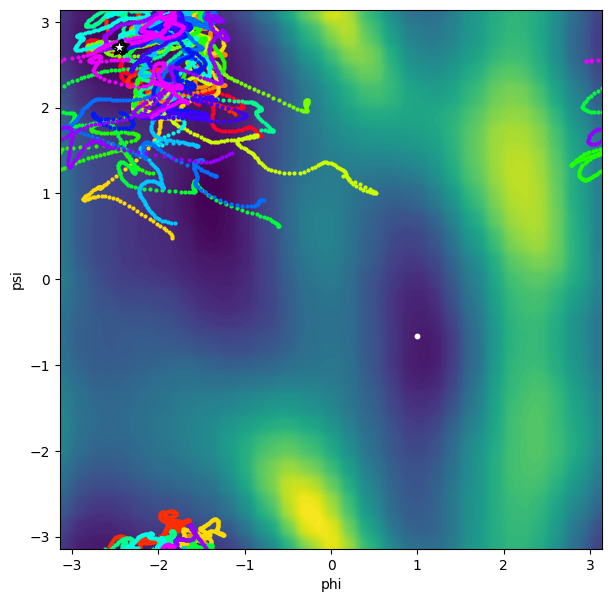

 10%|█         | 1/10 [00:46<06:59, 46.65s/it]

 ⬤  [0.998] - phi: 0.22, control: 0.13 
 ⬤  [0.000989] - phi: 0.3, control: 0.119 
 ⬤  [0.000705] - phi: 0.302, control: 0.121 
 ⬤  [1.86e-05] - phi: 0.332, control: 0.127 
 ⬤  [1.02e-06] - phi: 0.366, control: 0.122 
 ⬤  [1.27e-07] - phi: 0.38, control: 0.13 
 ⬤  [1.02e-09] - phi: 0.433, control: 0.125 
 ⬤  [9.78e-10] - phi: 0.432, control: 0.126 
 ⬤  [8.4e-10] - phi: 0.441, control: 0.118 
 ⬤  [8.24e-10] - phi: 0.431, control: 0.128 
 ⬤  [6.12e-10] - phi: 0.437, control: 0.125 
 ⬤  [2.38e-11] - phi: 0.473, control: 0.122 
 ⬤  [8.57e-14] - phi: 0.524, control: 0.127 
 ⬤  [2.68e-14] - phi: 0.534, control: 0.128 
 ⬤  [1.93e-14] - phi: 0.545, control: 0.121 
 ⬤  [6.22e-17] - phi: 0.601, control: 0.123 


100%|██████████| 500/500 [00:46<00:00, 10.75it/s]


[1 of 10] - phi: 0.3867514431476593, control: 0.1254843771457672


<Figure size 640x480 with 0 Axes>

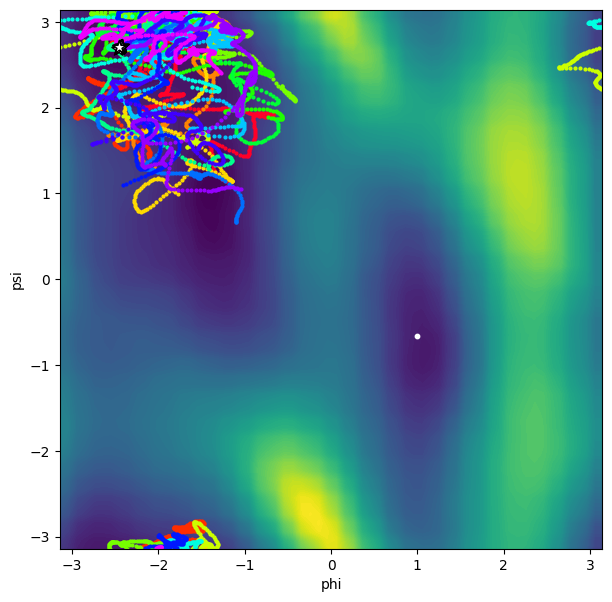

 20%|██        | 2/10 [01:34<06:20, 47.54s/it]

 ⬤  [0.573] - phi: 0.308, control: 0.126 
 ⬤  [0.159] - phi: 0.32, control: 0.127 
 ⬤  [0.0816] - phi: 0.329, control: 0.125 
 ⬤  [0.0648] - phi: 0.332, control: 0.124 
 ⬤  [0.053] - phi: 0.331, control: 0.127 
 ⬤  [0.047] - phi: 0.334, control: 0.125 
 ⬤  [0.0125] - phi: 0.348, control: 0.124 
 ⬤  [0.00596] - phi: 0.357, control: 0.123 
 ⬤  [0.00127] - phi: 0.364, control: 0.132 
 ⬤  [0.00121] - phi: 0.369, control: 0.127 
 ⬤  [3.64e-05] - phi: 0.407, control: 0.124 
 ⬤  [1.76e-05] - phi: 0.418, control: 0.12 
 ⬤  [4.52e-06] - phi: 0.429, control: 0.123 
 ⬤  [3.32e-06] - phi: 0.426, control: 0.129 
 ⬤  [9.65e-10] - phi: 0.509, control: 0.127 
 ⬤  [5.87e-14] - phi: 0.608, control: 0.125 


100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


[2 of 10] - phi: 0.4233062267303467, control: 0.12724116444587708


<Figure size 640x480 with 0 Axes>

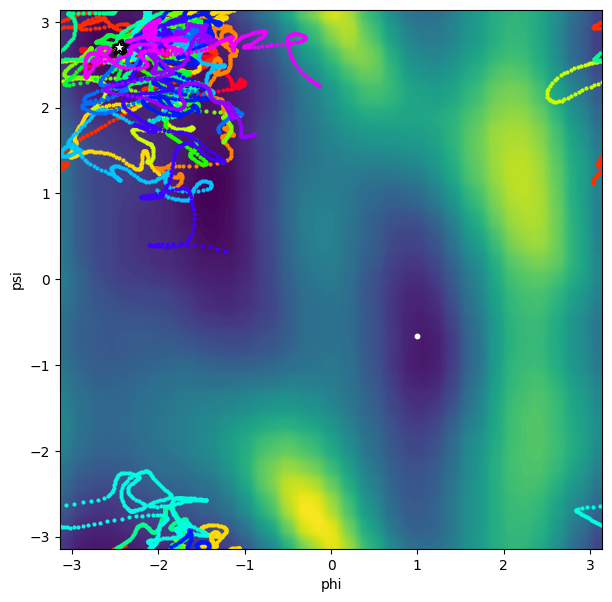

 30%|███       | 3/10 [02:20<05:26, 46.71s/it]

 ⬤  [0.609] - phi: 0.244, control: 0.127 
 ⬤  [0.367] - phi: 0.249, control: 0.127 
 ⬤  [0.0231] - phi: 0.275, control: 0.129 
 ⬤  [0.000565] - phi: 0.305, control: 0.136 
 ⬤  [0.00012] - phi: 0.33, control: 0.126 
 ⬤  [4.92e-05] - phi: 0.331, control: 0.134 
 ⬤  [1.97e-05] - phi: 0.348, control: 0.126 
 ⬤  [3.82e-08] - phi: 0.409, control: 0.127 
 ⬤  [1.2e-08] - phi: 0.414, control: 0.134 
 ⬤  [5.42e-09] - phi: 0.428, control: 0.128 
 ⬤  [7.39e-13] - phi: 0.518, control: 0.127 
 ⬤  [3.76e-13] - phi: 0.532, control: 0.12 
 ⬤  [2.77e-13] - phi: 0.536, control: 0.119 
 ⬤  [1.7e-13] - phi: 0.536, control: 0.124 
 ⬤  [1.43e-13] - phi: 0.535, control: 0.127 
 ⬤  [2.45e-24] - phi: 0.784, control: 0.126 


100%|██████████| 500/500 [00:47<00:00, 10.50it/s]


[3 of 10] - phi: 0.4398137331008911, control: 0.12434686720371246


<Figure size 640x480 with 0 Axes>

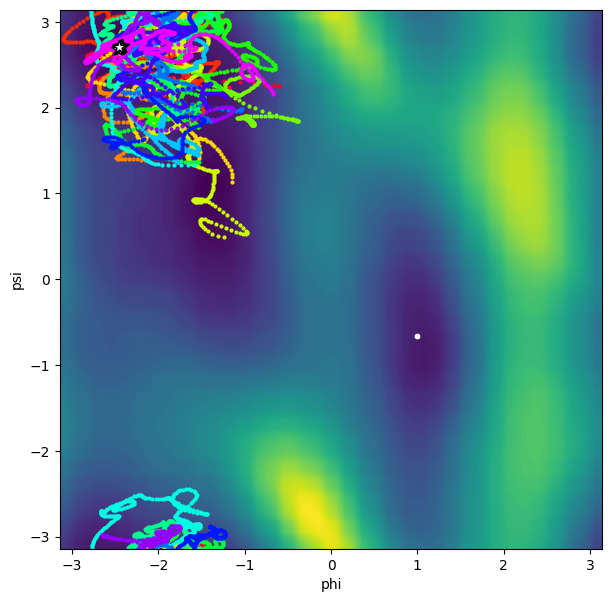

 40%|████      | 4/10 [03:09<04:45, 47.65s/it]

 ⬤  [0.988] - phi: 0.28, control: 0.13 
 ⬤  [0.00987] - phi: 0.333, control: 0.123 
 ⬤  [0.00173] - phi: 0.353, control: 0.121 
 ⬤  [0.000404] - phi: 0.362, control: 0.126 
 ⬤  [0.000269] - phi: 0.371, control: 0.121 
 ⬤  [8.38e-05] - phi: 0.373, control: 0.131 
 ⬤  [2.13e-06] - phi: 0.411, control: 0.129 
 ⬤  [6.12e-07] - phi: 0.429, control: 0.124 
 ⬤  [6.55e-08] - phi: 0.456, control: 0.12 
 ⬤  [4.84e-08] - phi: 0.456, control: 0.122 
 ⬤  [3.49e-08] - phi: 0.455, control: 0.127 
 ⬤  [5.13e-10] - phi: 0.509, control: 0.115 
 ⬤  [3.91e-10] - phi: 0.507, control: 0.12 
 ⬤  [3.41e-12] - phi: 0.545, control: 0.129 
 ⬤  [2.13e-12] - phi: 0.555, control: 0.124 
 ⬤  [2.05e-16] - phi: 0.642, control: 0.129 


100%|██████████| 500/500 [00:44<00:00, 11.24it/s]


[4 of 10] - phi: 0.4813365638256073, control: 0.12585213780403137


<Figure size 640x480 with 0 Axes>

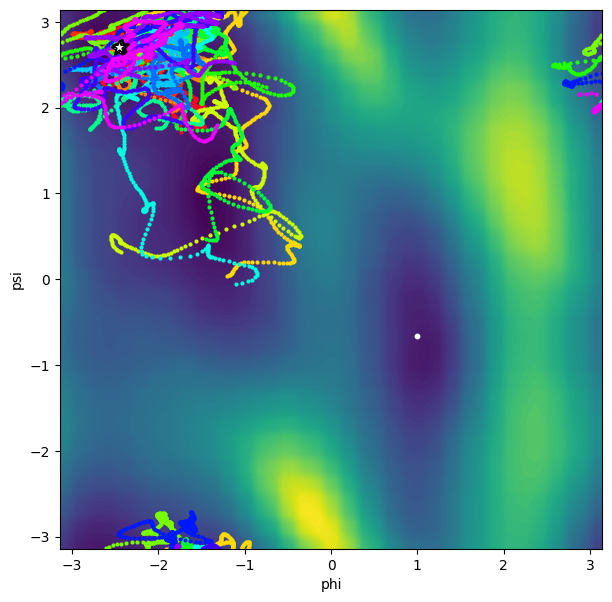

 50%|█████     | 5/10 [03:55<03:55, 47.04s/it]

 ⬤  [0.956] - phi: 0.248, control: 0.125 
 ⬤  [0.044] - phi: 0.277, control: 0.127 
 ⬤  [0.000399] - phi: 0.323, control: 0.128 
 ⬤  [3.38e-05] - phi: 0.349, control: 0.126 
 ⬤  [1.41e-05] - phi: 0.358, control: 0.126 
 ⬤  [5.53e-06] - phi: 0.37, control: 0.123 
 ⬤  [7.45e-08] - phi: 0.405, control: 0.132 
 ⬤  [1.27e-09] - phi: 0.452, control: 0.126 
 ⬤  [9.04e-11] - phi: 0.476, control: 0.128 
 ⬤  [3.21e-12] - phi: 0.512, control: 0.125 
 ⬤  [3.15e-15] - phi: 0.586, control: 0.12 
 ⬤  [6.26e-17] - phi: 0.622, control: 0.124 
 ⬤  [1.71e-17] - phi: 0.638, control: 0.121 
 ⬤  [1.5e-17] - phi: 0.632, control: 0.128 
 ⬤  [8.42e-21] - phi: 0.711, control: 0.124 
 ⬤  [2.47e-22] - phi: 0.74, control: 0.13 


100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


[5 of 10] - phi: 0.41821151971817017, control: 0.12534426152706146


<Figure size 640x480 with 0 Axes>

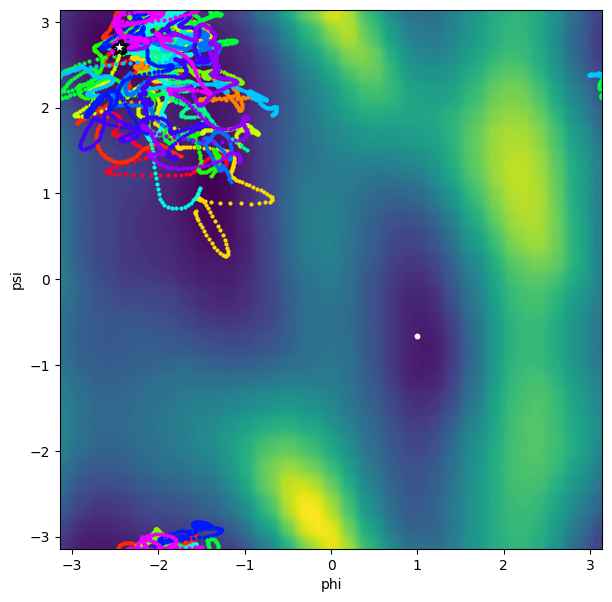

 60%|██████    | 6/10 [04:45<03:11, 47.90s/it]

 ⬤  [0.997] - phi: 0.237, control: 0.129 
 ⬤  [0.0024] - phi: 0.303, control: 0.122 
 ⬤  [0.000548] - phi: 0.314, control: 0.126 
 ⬤  [8.28e-06] - phi: 0.356, control: 0.126 
 ⬤  [3.9e-07] - phi: 0.384, control: 0.129 
 ⬤  [3.35e-07] - phi: 0.389, control: 0.126 
 ⬤  [8.4e-08] - phi: 0.406, control: 0.122 
 ⬤  [5.2e-08] - phi: 0.406, control: 0.127 
 ⬤  [2.4e-08] - phi: 0.416, control: 0.125 
 ⬤  [6.31e-09] - phi: 0.426, control: 0.128 
 ⬤  [2.15e-09] - phi: 0.447, control: 0.118 
 ⬤  [7.99e-12] - phi: 0.493, control: 0.128 
 ⬤  [3.66e-12] - phi: 0.505, control: 0.123 
 ⬤  [2.68e-12] - phi: 0.508, control: 0.123 
 ⬤  [3.7e-13] - phi: 0.524, control: 0.128 
 ⬤  [1.8e-15] - phi: 0.578, control: 0.127 


100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


[6 of 10] - phi: 0.42589232325553894, control: 0.12584730982780457


<Figure size 640x480 with 0 Axes>

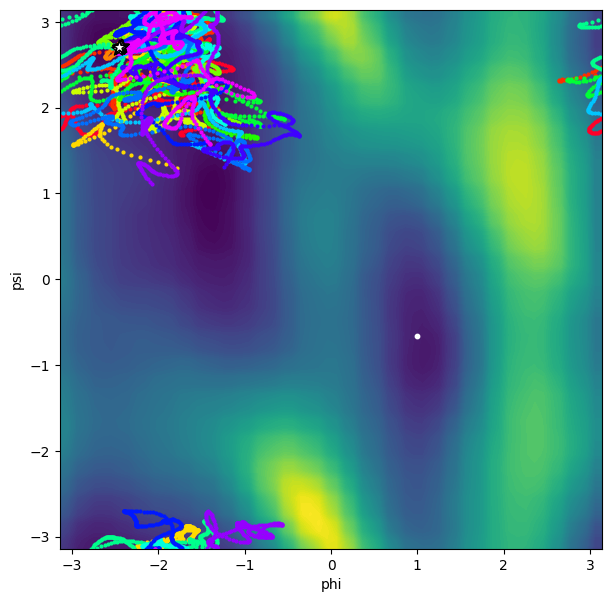

 70%|███████   | 7/10 [05:30<02:21, 47.15s/it]

 ⬤  [0.999] - phi: 0.239, control: 0.126 
 ⬤  [0.000667] - phi: 0.312, control: 0.126 
 ⬤  [0.00047] - phi: 0.316, control: 0.126 
 ⬤  [0.000155] - phi: 0.329, control: 0.123 
 ⬤  [6.01e-05] - phi: 0.341, control: 0.121 
 ⬤  [3.69e-06] - phi: 0.366, control: 0.124 
 ⬤  [2.19e-06] - phi: 0.367, control: 0.128 
 ⬤  [2.02e-06] - phi: 0.363, control: 0.133 
 ⬤  [1.91e-07] - phi: 0.397, control: 0.123 
 ⬤  [1.13e-09] - phi: 0.443, control: 0.127 
 ⬤  [2.38e-10] - phi: 0.456, control: 0.131 
 ⬤  [1.79e-11] - phi: 0.484, control: 0.128 
 ⬤  [1.48e-11] - phi: 0.491, control: 0.123 
 ⬤  [2.06e-15] - phi: 0.582, control: 0.121 
 ⬤  [1.08e-17] - phi: 0.628, control: 0.128 
 ⬤  [7.48e-21] - phi: 0.701, control: 0.127 


100%|██████████| 500/500 [00:47<00:00, 10.50it/s]


[7 of 10] - phi: 0.4110492765903473, control: 0.1261765956878662


<Figure size 640x480 with 0 Axes>

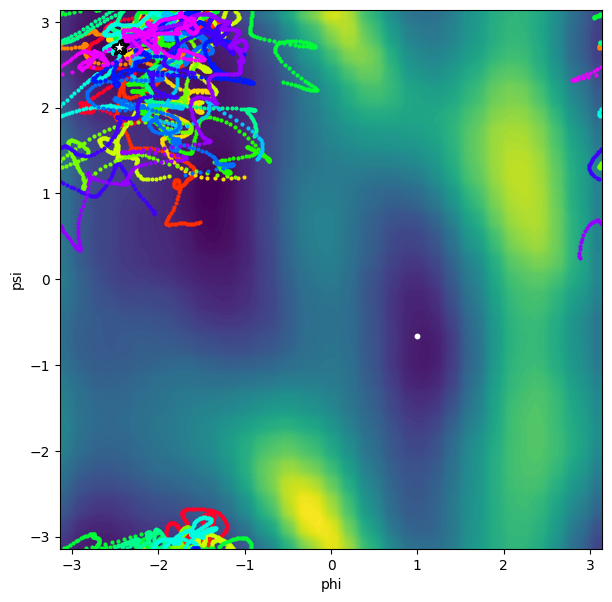

 80%|████████  | 8/10 [06:19<01:35, 47.76s/it]

 ⬤  [0.877] - phi: 0.301, control: 0.127 
 ⬤  [0.0385] - phi: 0.333, control: 0.126 
 ⬤  [0.0343] - phi: 0.335, control: 0.125 
 ⬤  [0.0305] - phi: 0.335, control: 0.126 
 ⬤  [0.0174] - phi: 0.348, control: 0.119 
 ⬤  [0.00138] - phi: 0.373, control: 0.12 
 ⬤  [0.000799] - phi: 0.367, control: 0.131 
 ⬤  [6.89e-05] - phi: 0.395, control: 0.128 
 ⬤  [6.43e-05] - phi: 0.389, control: 0.134 
 ⬤  [4.28e-05] - phi: 0.404, control: 0.123 
 ⬤  [2.08e-05] - phi: 0.403, control: 0.131 
 ⬤  [1.37e-05] - phi: 0.408, control: 0.13 
 ⬤  [3.93e-09] - phi: 0.489, control: 0.131 
 ⬤  [1.68e-11] - phi: 0.552, control: 0.123 
 ⬤  [2.45e-12] - phi: 0.572, control: 0.122 
 ⬤  [2.11e-12] - phi: 0.573, control: 0.122 


100%|██████████| 500/500 [00:43<00:00, 11.38it/s]


[8 of 10] - phi: 0.4212386906147003, control: 0.12570983171463013


<Figure size 640x480 with 0 Axes>

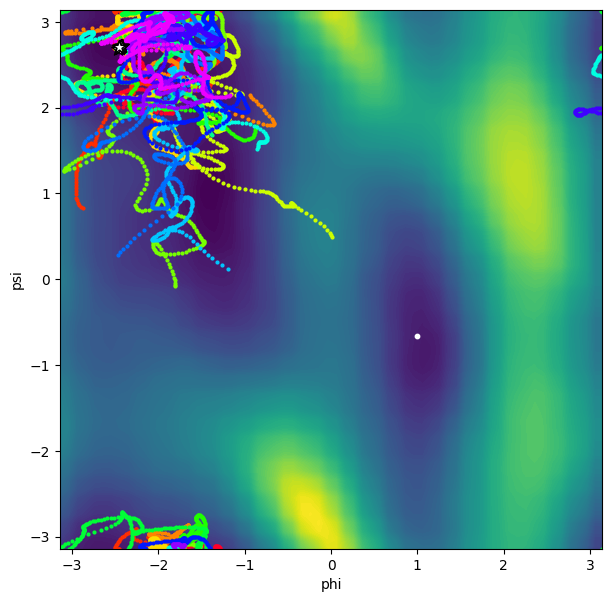

 90%|█████████ | 9/10 [07:05<00:47, 47.03s/it]

 ⬤  [0.996] - phi: 0.246, control: 0.129 
 ⬤  [0.0032] - phi: 0.313, control: 0.119 
 ⬤  [0.000637] - phi: 0.32, control: 0.128 
 ⬤  [0.000236] - phi: 0.331, control: 0.128 
 ⬤  [0.000163] - phi: 0.334, control: 0.129 
 ⬤  [8.39e-05] - phi: 0.343, control: 0.126 
 ⬤  [5.27e-05] - phi: 0.345, control: 0.128 
 ⬤  [1.46e-06] - phi: 0.383, control: 0.126 
 ⬤  [5.01e-08] - phi: 0.416, control: 0.127 
 ⬤  [2.43e-09] - phi: 0.451, control: 0.122 
 ⬤  [3.28e-10] - phi: 0.475, control: 0.118 
 ⬤  [3.11e-11] - phi: 0.49, control: 0.127 
 ⬤  [2.93e-12] - phi: 0.513, control: 0.128 
 ⬤  [1.05e-12] - phi: 0.52, control: 0.131 
 ⬤  [1.45e-13] - phi: 0.549, control: 0.122 
 ⬤  [1.03e-20] - phi: 0.711, control: 0.124 


100%|██████████| 500/500 [00:46<00:00, 10.65it/s]


[9 of 10] - phi: 0.3951556980609894, control: 0.12834584712982178


<Figure size 640x480 with 0 Axes>

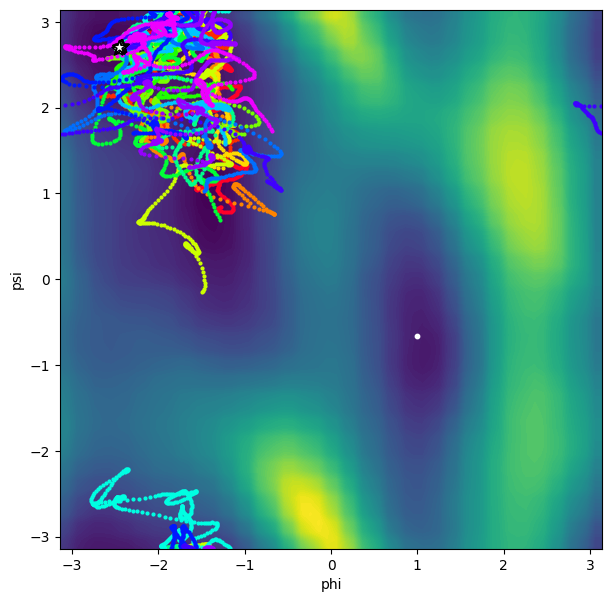

100%|██████████| 10/10 [07:53<00:00, 47.38s/it]

 ⬤  [0.805] - phi: 0.243, control: 0.131 
 ⬤  [0.134] - phi: 0.263, control: 0.129 
 ⬤  [0.0524] - phi: 0.272, control: 0.129 
 ⬤  [0.00902] - phi: 0.295, control: 0.123 
 ⬤  [6.41e-05] - phi: 0.338, control: 0.13 
 ⬤  [5.15e-05] - phi: 0.341, control: 0.129 
 ⬤  [1.52e-05] - phi: 0.355, control: 0.127 
 ⬤  [1.12e-05] - phi: 0.356, control: 0.13 
 ⬤  [4.22e-07] - phi: 0.393, control: 0.125 
 ⬤  [1.4e-07] - phi: 0.401, control: 0.128 
 ⬤  [9.55e-08] - phi: 0.403, control: 0.129 
 ⬤  [2.75e-11] - phi: 0.489, control: 0.126 
 ⬤  [8.82e-12] - phi: 0.496, control: 0.13 
 ⬤  [2.38e-12] - phi: 0.509, control: 0.13 
 ⬤  [1.5e-14] - phi: 0.56, control: 0.129 
 ⬤  [1.1e-16] - phi: 0.609, control: 0.13 


In [18]:
for r in tqdm(range(0, n_rollouts)):
    # We have to manually keep track of the grads as we need to weight them by the final costs of the paths.
    policy_optimizers.zero_grad()
    grad_policy = []

    # Initialize start positions of path
    paths[:, 0, :] = get_starting_positions(MDs)
    new_state = paths[:, 0, :].to(device)

    for s in tqdm(range(0, n_steps)):
        x = new_state.detach()
        t = torch.tensor(s * dt)

        # Sample control and noise
        update_u = policy(x, t)
        update_eps = eps_distr.sample()
        update_action = (update_u + update_eps) * dt

        # We need to get the gradient wrt the parameters for each input individually as we need to scale them later based on the score for each trajectory
        for n in range(0, n_samples):
            tmp_ = -1 * R @ (update_eps[n]) * dt
            if n == (n_samples-1):
                tmp = torch.autograd.grad(update_u[n], policy.parameters(), retain_graph=False, allow_unused=True, grad_outputs=tmp_)
            else:
                tmp = torch.autograd.grad(update_u[n], policy.parameters(), retain_graph=True, allow_unused=True, grad_outputs=tmp_)# * dt

            if s == 0:
                grad_policy.append(tmp)
            else:
                grad_policy[n] = tuple(sum(x) for x in zip(grad_policy[n], tmp))

        # Perform OpenMM step
        positions = run_simulations(MDs, update_action)
        new_state = positions.to(device)

        # Bookkeeping
        paths[:, s+1, :]  = new_state
        history_control[:, s, :] = update_u
        history_noise[:, s, :] = update_eps

    # Calculate losses
    cost_phi = phi(paths, ending_positions)
    cost_control = control_cost(history_control, history_noise, R) / T

    path_cost = (1/lambda_) * (cost_phi + cost_control)
    path_cost = path_cost - path_cost.min()
    path_cost = torch.exp(-path_cost)
    normalizing_constant = path_cost.sum()

    # Scale gradients
    for t_idx, t in enumerate(grad_policy):
        for param_idx, param in enumerate(t):
            param = param.to(device)
            if t_idx == 0:
                policy_optimizers.param_groups[0]['params'][param_idx].grad = torch.zeros_like(param)
            scaled_param = (param * path_cost[t_idx]) / normalizing_constant

            # Update optimizer with scaled gradients
            policy_optimizers.param_groups[0]['params'][param_idx].grad += scaled_param

    # Perform gradient step
    policy_optimizers.step()

    # Reset the MD simulations
    reset(MDs)

    # Print results
    print(f"[{r} of {n_rollouts}] - phi: {cost_phi.mean()}, control: {cost_control.mean()}")

    order = (-path_cost/normalizing_constant).argsort()
    if plot:
        colors = PlotPathsAlanine(paths, ending_positions)

        for i in order:
            c = colors[i][:3]
            c = [int(c_ * 255) for c_ in c]

            print(f"\033[38;2;{c[0]};{c[1]};{c[2]}m \u2B24 \033[38;2;0;0;0m ["
                  f"{path_cost[i]/normalizing_constant:.3}] - phi:"
                  f" {cost_phi[i]:.3}, "
                  f"control:"
                  f" {cost_control[i]:.3} ")
            
    else: 
        for i in order:

            print(f"\033[38;2;0;0;0m \u2B24 ["
                  f"{path_cost[i]/normalizing_constant:.3}] - phi:"
                  f" {cost_phi[i]:.3}, "
                  f"control:"
                  f" {cost_control[i]:.3} ")
            
    # Save last set of trajectories for plotting
    last_order = order
    last_paths = paths.clone()

## Sampling

Now that we have trained the policy (or just loaded the weights in), we can use it to sample trajectories.


In [19]:
policy = torch.load("./policies/policy_2806", map_location=device)
policy.vel_given = False

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_3044342/2225695769.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(s * dt)
100%|██████████| 500/500 [00:31<00:00, 15.66it/s]


<Figure size 640x480 with 0 Axes>

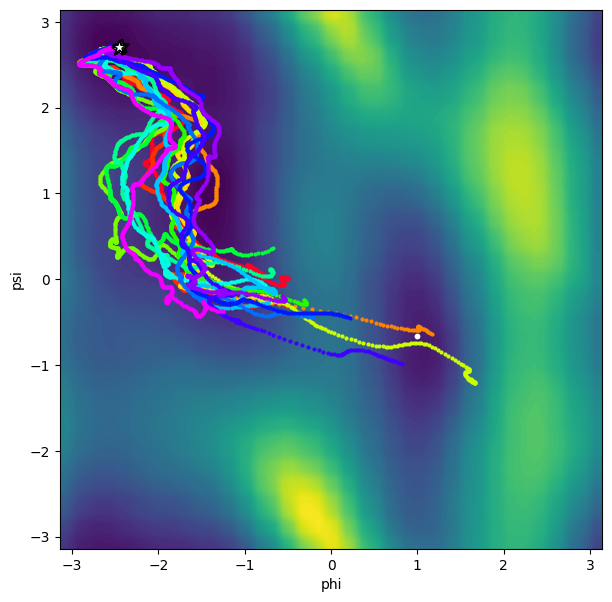

In [20]:
reset(MDs)

# Initialize start positions of path
paths[:, 0, :] = get_starting_positions(MDs)
new_state = paths[:, 0, :].to(device)

for s in tqdm(range(0, n_steps)):
    x = new_state.detach()
    # t = torch.tensor(s * dt)
    t = (s * dt).clone().detach()

    # Sample control and noise
    update_u = policy(x, t)
    update_action = update_u * dt

    # Perform OpenMM step
    positions = run_simulations(MDs, update_action)
    new_state = positions.to(device)

    # Bookkeeping
    paths[:, s+1, :]  = new_state

# Reset the MD simulations
reset(MDs)

# Print results
phi_cost = phi(paths, ending_positions)
order = phi_cost.argsort()
colors = PlotPathsAlanine(paths, ending_positions)
            
# Save last set of trajectories for plotting
last_order = order
last_paths = paths.clone()

### Plotting
Below we have included some additional visualization that takes the best path from the last run and visualizes it in 3D. 

In [17]:
import numpy as np
import mdtraj as md

STEP = 1

# Get best trajectory
best = last_order[0]
best_traj = last_paths[best].view(last_paths[best].shape[0], -1, 3)

trajs = None
for j in range(0, int(best_traj.shape[0]), STEP):
    traj = md.load_pdb('./potentials/files/AD_c7ax.pdb')
    
    atoms = []
    traj.xyz = np.array(best_traj[j].cpu())
    
    if j == 0:
        trajs = traj
    else:
        trajs = trajs.join(traj)


In [18]:
import nglview
view = nglview.show_mdtraj(trajs)
view

NGLWidget(max_frame=500)